### Data Processing

In [24]:
!pip3 install tensorflow==2.3.0

     |████████████████████████████████| 320.4MB 51kB/s 
     |████████████████████████████████| 20.1MB 65.2MB/s 
     |████████████████████████████████| 2.9MB 49.2MB/s 
     |████████████████████████████████| 460kB 47.3MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Found existing installation: tensorflow

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

### Modelling

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization,Dense,Conv2D,Reshape,Conv2DTranspose,ReLU,LeakyReLU,Flatten,Activation
from tensorflow.keras.optimizers import  Adam

In [29]:
class DCGAN:
  def __init__(self,training_images):

    ### Considering channels last

    self.no_of_samples=training_images.shape[0]
    self.height=training_images.shape[1]
    self.width=training_images.shape[2]
    self.channels=training_images.shape[3]
    self.train_data=(training_images-127.5)/127.5 ### Converting grey scale [0-255] -> [-1,1]
    self.shape=(self.height,self.width,self.channels)
    self.noise_size=100
    self.Discriminator=None
    self.Generator=None
    self.GAN_model=None

  def get_generator(self):

    ### Generator definition

    w_init=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    Generator= Sequential()

    ### Input layer: takes in input a random noise of 100 points distributed in a random distribution 
    Generator.add(Dense(7*7*256, input_shape=(self.noise_size,),kernel_initializer=w_init))
    Generator.add(BatchNormalization())
    Generator.add(LeakyReLU(alpha=0.1))

    ### Reshaping layer to reshape in image dimension
    Generator.add(Reshape((7,7,256)))

    ### Upconv layer 1  ## The size remains constant (7 x 7 x 128)
    Generator.add(Conv2DTranspose(128, (5,5), strides=(1,1),padding="same",kernel_initializer=w_init))
    Generator.add(BatchNormalization())
    Generator.add(LeakyReLU(alpha=0.1))

    ### Upconv layer 2  ## The size upsamples by 2 (14 x 14 x 128)
    Generator.add(Conv2DTranspose(64, (5,5), strides=(2,2),padding="same",kernel_initializer=w_init))
    Generator.add(BatchNormalization())
    Generator.add(LeakyReLU(alpha=0.1))

    ### Upconv layer 3  ## The size upsamples by 2 (28 x 28 x 1)
    Generator.add(Conv2DTranspose(self.channels, (5,5), strides=(2,2),padding="same",kernel_initializer=w_init))
    Generator.add(Activation('tanh'))

    ### generator output must be of the dimension of the input shape of the image data: (28,28,1)
    ### The last layer uses tanh activation in the generator. 
    return Generator

  def get_discriminator(self):    
    
    ### Discriminator definition
    w_init=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    Discriminator= Sequential()

    ### Input layer: Conv layer 1
    Discriminator.add(Conv2D(64, (5,5), strides=(2,2),input_shape=self.shape,padding="same",kernel_initializer=w_init))
    Discriminator.add(BatchNormalization())
    Discriminator.add(LeakyReLU(alpha=0.01))

    ### Conv layer 2
    Discriminator.add(Conv2D(128, (5,5), strides=(2,2),padding="same",kernel_initializer=w_init))
    Discriminator.add(BatchNormalization())
    Discriminator.add(LeakyReLU(alpha=0.01))

    ### Flatten
    Discriminator.add(Flatten())

    ### Dense layer 1
    Discriminator.add(Dense(128,kernel_initializer=w_init))
    Discriminator.add(LeakyReLU(alpha=0.01))

    ### Prediction layer
    Discriminator.add(Dense(1,activation="sigmoid",kernel_initializer=w_init))

    # Discriminator compilation

    return Discriminator

  def get_GAN(self):  

    ### GAN models is made by combining the Generator and Discriminator models

    ### Initialization 
    GAN_model=Sequential()

    ### Adding generator
  
    GAN_model.add(self.Generator)

    ### Adding Discriminator
    GAN_model.add(self.Discriminator)

    GAN_model.compile(loss="binary_crossentropy",optimizer=Adam(learning_rate=0.0002,beta_1=0.5))

    return GAN_model

  def get_all_models(self):

    self.Discriminator=self.get_discriminator()

    self.Generator=self.get_generator()

    self.GAN_model=self.get_GAN()

    ### Compiling discriminator

    self.Discriminator.compile(loss="binary_crossentropy",optimizer=Adam(learning_rate=0.0002,beta_1=0.5))

    """print("------------ DISCRIMINATOR------------------")
    print(self.Discriminator.summary())
    print("------------ GENERATOR------------------")
    print(self.Generator.summary())
    print("------------ GAN------------------")
    print(self.GAN_model.summary())"""
    
    return None

  def show_images(self, rows=4, columns=4):

    z = np.random.uniform(-1.0, 1.0, size=[rows*columns, self.noise_size])
    #z=np.random.normal(0, 1, (rows*columns, noise_size))
    generated_images = self.Generator.predict(z)

    generated_images= (generated_images - (-1))/(1 - (-1))

    ### Min-Max scaling to convert pixles from [-1,1] -> [0,1]

    ### Plotting
    fig, ax = plt.subplots(rows,columns, figsize=(6,6))

    for i in range(rows):
      for j in range(columns):
        ax[i,j].imshow(generated_images[i+j,:,:,0],cmap="gray")
    plt.show()
  
  def train(self,epochs,batch_size):

    self.get_all_models()  ### Initializing all models

    gen_loss=[]
    dis_loss=[]

    dis_accuracy=[]
    
    history={}

    real_labels=np.ones((batch_size,1)) ### For the real images, the label: 1
    ### The discriminator must predict 1 for the real images

    fake_labels=np.zeros((batch_size,1))### For the fake images, generated by the generator, the label: 0
    ### The discriminator must predict 0 for the fake images

    for epoch in range(epochs):      ### Training epochs

      ########    DISCRIMINATOR TRAINING    #########

      self.Discriminator.trainable=True

      indexes= np.random.randint(0,self.no_of_samples, batch_size)

      ### Indexes have the random indexes betweeen 0 and number of samples in the training data. The number of generated
      ### indexes is equal to the batch size

      samples= self.train_data[indexes]   ### Creating batch

      z = np.random.uniform(-1.0, 1.0, size=[batch_size, self.noise_size]) ### Produces batch_size number of 100 dimensional noise arrays of uniform distribution
      
      generated=self.Generator.predict(z)  ### obtaining the generated images

      training_set_of_discriminator=np.concatenate((samples,generated))
      labels_of_discriminator=np.concatenate((real_labels.copy(),fake_labels))

      ### Records discriminator loss for the real images. So, the target labels are all 1s
      ### Records discriminator loss for the generated fake images. So, the target labels are all 0s


      #### Train_on batch: Scalar training loss (if the model has a single output and no metrics) or list of scalars 
      #### (if the model has multiple outputs and/or metrics). The attribute model.metrics_names will give you the display labels for the scalar outputs.

      loss_disc=self.Discriminator.train_on_batch(training_set_of_discriminator,labels_of_discriminator)
      pred_disc=np.round(self.Discriminator.predict(training_set_of_discriminator))
      acc_disc=(pred_disc==labels_of_discriminator).mean()

      #### Train_on batch: Scalar training loss (if the model has a single output and no metrics) or list of scalars 
      #### (if the model has multiple outputs and/or metrics). The attribute model.metrics_names will give you the display labels for the scalar outputs.


      ########    GENERATOR TRAINING    #########

      self.Discriminator.trainable=False ### For Generator training the discriminator is not trained

      #z = np.random.uniform(-1.0, 1.0, size=[batch_size, self.noise_size]) ### Produces batch_size number of 100 dimensional noise arrays of uniform distribution

      loss_generator=self.GAN_model.train_on_batch(z,real_labels) ### Discriminator is fixed, so the loss is actually genertors
      pred_gan=np.round(self.GAN_model.predict(z))
      acc_gan=(pred_gan==real_labels).mean()
      if epoch%50==0:
          print(f"ON EPOCH {epoch}  Discriminator Loss: {loss_disc},Discriminator accuracy: {acc_disc}, Generator loss: {loss_generator}, Generator accuracy: {acc_gan}")
    

      ### The generator creates images from the random noise, the GAN  model has generator layer added on top of the 
      ### Discriminator model, so, it's input is the noise for the generator.

      ### The generator produces the generated images, which are passed to the discriminator. The discriminator
      ### predicts the labels for the images, so the label is the target value

      ### The generator wants the discriminator to predict all its objects with label 1. So, the actual labels are passed 1.
      ### The error of the generator high if the discriminator distinguishes the image as a fake and produce 0 as prediction.

      #dis_loss.append(loss_disc)
      #dis_accuracy.append(acc_disc)

      #gen_loss.append(loss_generator)

      #if epoch%100==0:
        #self.show_images()

   
  
    #history["Discriminator loss"]=dis_loss
    #history["Discriminator accuracy"]=dis_accuracy

    #history["Generator loss"]=gen_loss
    #return history

  






In [30]:
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.mnist.load_data(path="mnist.npz")
x_train=x_train.reshape((x_train.shape[0],x_train.shape[1],x_train.shape[2],1))


In [31]:
GAN=DCGAN(x_train)

In [32]:
history=GAN.train(500,128)

ON EPOCH 0  Discriminator Loss: 0.7709858417510986,Discriminator accuracy: 0.62109375, Generator loss: 0.6152706146240234, Generator accuracy: 1.0


KeyboardInterrupt: 

In [2]:
tf.__version__

'2.3.0'

### Training

In [2]:
def show_images(gen, rows=4, columns=4):

  noise_size=100

  z=tf.random.uniform([rows*columns,noise_size])
  #z=np.random.normal(0, 1, (rows*columns, noise_size))
  generated_images = gen.predict(z)

  generated_images= (generated_images - (-1))/(1 - (-1))

  ### Min-Max scaling to convert pixles from [-1,1] -> [0,1]

  ### Plotting
  fig, ax = plt.subplots(rows,columns, figsize=(6,6))

  for i in range(rows):
    for j in range(columns):
      ax[i,j].imshow(generated_images[i+j,:,:,0],cmap="gray")
  plt.show()

In [24]:
def train(epochs, batch_size):
  gen_loss=[]
  dis_loss=[]

  dis_accuracy=[]
  
  history={}

  noise_size=100          ### The dimension of the noise as given in the input of generator
  
  X_train=get_data()      ###Getting the training data

  real_labels=np.ones((batch_size,1)) ### For the real images, the label: 1
  ### The discriminator must predict 1 for the real images

  fake_labels=np.zeros((batch_size,1))### For the fake images, generated by the generator, the label: 0
  ### The discriminator must predict 0 for the fake images

  for epoch in range(epochs):      ### Training epochs

      ########    DISCRIMINATOR TRAINING    #########
     
      indexes= np.random.randint(0, X_train.shape[0], batch_size)

      ### Indexes have the random indexes betweeen 0 and number of samples in the X_train. The number of generated
      ### indexes is equal to the batch size

      samples= X_train[indexes]   ### Creating batch

      z=tf.random.uniform([batch_size,noise_size]) ### Produces batch_size number of 100 dimensional noise arrays of uniform distribution
      
      #z=np.random.normal(0, 1, (batch_size, noise_size)) ### 0->mean, 1->std dev ->normal distribution->bell curve
      ### Number of values is batch_size x noise_size

      generated=Generator.predict(z)  ### obtaining the generated images

      real_loss_disc,real_acc_disc=Discriminator.train_on_batch(samples,real_labels) ### Records discriminator loss
      ### for the real images. So, the target labels are all 1s

      #### Train_on batch: Scalar training loss (if the model has a single output and no metrics) or list of scalars 
      #### (if the model has multiple outputs and/or metrics). The attribute model.metrics_names will give you the display labels for the scalar outputs.


      fake_loss_disc,fake_acc_disc=Discriminator.train_on_batch(generated,fake_labels) ### Records discriminator loss
      ### for the generated fake images. So, the target labels are all 0s

      Total_loss= (real_loss_disc+fake_loss_disc)/2 ### Averaging to obtain actual loss

      Total_acc= (real_acc_disc+fake_acc_disc)/2 ### Averaging to obtain actual accuracy

      ########    GENERATOR TRAINING    #########

      z=tf.random.uniform([batch_size,noise_size]) ### Produces batch_size number of 100 dimensional noise arrays of uniform distribution
      #z=np.random.normal(0, 1, (batch_size, noise_size))

      generated=Generator.predict(z)  ### obtaining the generated images

      loss_generator=GAN.train_on_batch(z,real_labels) ### Discriminator is fixed, so the loss is actually genertors

      ### The generator creates images from the random noise, the GAN  model has generator layer added on top of the 
      ### Discriminator model, so, it's input is the noise for the generator.

      ### The generator produces the generated images, which are passed to the discriminator. The discriminator
      ### predicts the labels for the images, so the label is the target value

      ### The generator wants the discriminator to predict all its objects with label 1. So, the actual labels are passed 1.
      ### The error of the generator high if the discriminator distinguishes the image as a fake and produce 0 as prediction.

      dis_loss.append(Total_loss)
      dis_accuracy.append(Total_acc)

      gen_loss.append(loss_generator)

      if epoch%500==0:
        show_images(Generator)

        print(f"ON EPOCH {epoch} Discriminator Loss: {Total_loss}, Discriminator accurcy: {Total_acc}, Generator loss: {loss_generator}")
  
  history["Discriminator loss"]=dis_loss
  history["Discriminator accuracy"]=dis_accuracy

  history["Generator loss"]=gen_loss
  return history






      

      












 



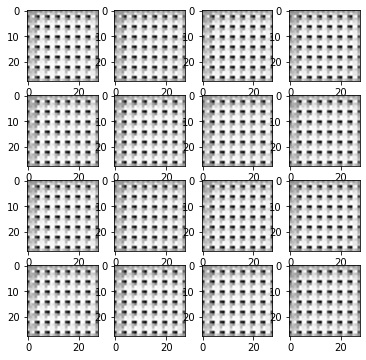

ON EPOCH 0 Discriminator Loss: 2.843249797821045, Discriminator accurcy: 0.5, Generator loss: 0.7274882793426514


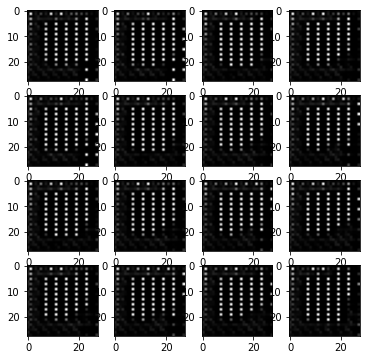

ON EPOCH 500 Discriminator Loss: 4.581279426929541e-06, Discriminator accurcy: 1.0, Generator loss: 0.0016524032689630985


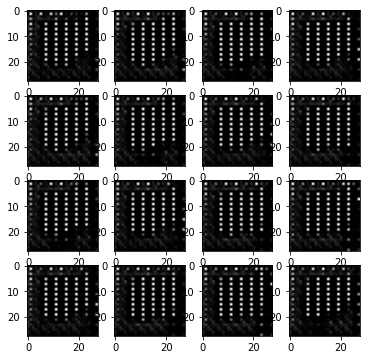

ON EPOCH 1000 Discriminator Loss: 2.213523202954093e-06, Discriminator accurcy: 1.0, Generator loss: 0.00033713062293827534


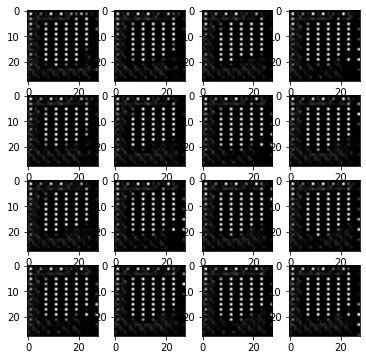

ON EPOCH 1500 Discriminator Loss: 1.4431262798098032e-06, Discriminator accurcy: 1.0, Generator loss: 0.0001477132027503103


KeyboardInterrupt: ignored

In [25]:
train(30000,128)